### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
model_name = 'exp-model-l14-keras-embedding-small-rm-67'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

# cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

rare_village_threshold = 1
rare_town_threshold = 1

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
train.head(5)
test.head(5)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: 146

Target mean encoded columns: 0

Right skew columns: 57


### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=1, rare_town_threshold=1):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
        # Rare village and town threshold
        self.rare_village_threshold = rare_village_threshold
        self.rare_town_threshold = rare_town_threshold
        
    def fit_transform(self, df, df_test):
        df = df.copy()
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan        
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [13]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate
from keras.optimizers import Adam, SGD
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [24]:
from keras_get_best import GetBest

def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*7, learning_rate=0.001, optimizer=Adam):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for n in n_neurons:
        x_layer = Dense(n, activation='relu', kernel_initializer='he_uniform')(x_layer)
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    model.compile(optimizer=optimizer(lr=learning_rate), loss='mae', metrics=['mse'])
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for i, hist in enumerate(hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+str(i), alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

### Params

In [15]:
params = {'epochs': 200,
          'n_neurons': (512,)*3+(256,)*4,
          'optimizer': Adam,
          'learning_rate': 0.001,
          'batch_size': 64,
         }

### kfold cross-predict

In [16]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                        n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                        optimizer=params['optimizer'])

    # Train model
    hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                     verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])
    best_iterations.append(np.argmin(hist.history['val_loss'])+1)
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====


W0629 22:53:35.336239 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 22:53:35.365253 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 22:53:35.367778 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 209, 'village': 2606, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56


W0629 22:53:35.644294 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 22:53:35.828608 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0629 22:53:36.068506 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 48000 samples, validate on 12000 samples
Epoch 1/200
 - 8s - loss: 0.2545 - mean_squared_error: 0.1232 - val_loss: 0.2127 - val_mean_squared_error: 0.0846
Epoch 2/200
 - 7s - loss: 0.1998 - mean_squared_error: 0.0774 - val_loss: 0.2026 - val_mean_squared_error: 0.0784
Epoch 3/200
 - 7s - loss: 0.1834 - mean_squared_error: 0.0676 - val_loss: 0.1847 - val_mean_squared_error: 0.0665
Epoch 4/200
 - 7s - loss: 0.1738 - mean_squared_error: 0.0612 - val_loss: 0.1782 - val_mean_squared_error: 0.0632
Epoch 5/200
 - 7s - loss: 0.1678 - mean_squared_error: 0.0580 - val_loss: 0.1856 - val_mean_squared_error: 0.0665
Epoch 6/200
 - 7s - loss: 0.1618 - mean_squared_error: 0.0542 - val_loss: 0.1725 - val_mean_squared_error: 0.0602
Epoch 7/200
 - 7s - loss: 0.1547 - mean_squared_error: 0.0505 - val_loss: 0.1736 - val_mean_squared_error: 0.0604
Epoch 8/200
 - 7s - loss: 0.1500 - mean_squared_error: 0.0480 - val_loss: 0.1748 - val_mean_squared_error: 0.0602
Epoch 9/200
 - 7s - loss: 0.1447 - mea

Epoch 72/200
 - 7s - loss: 0.0508 - mean_squared_error: 0.0077 - val_loss: 0.1538 - val_mean_squared_error: 0.0519
Epoch 73/200
 - 7s - loss: 0.0505 - mean_squared_error: 0.0077 - val_loss: 0.1535 - val_mean_squared_error: 0.0517
Epoch 74/200
 - 7s - loss: 0.0496 - mean_squared_error: 0.0075 - val_loss: 0.1521 - val_mean_squared_error: 0.0511
Epoch 75/200
 - 7s - loss: 0.0491 - mean_squared_error: 0.0073 - val_loss: 0.1528 - val_mean_squared_error: 0.0513
Epoch 76/200
 - 7s - loss: 0.0488 - mean_squared_error: 0.0073 - val_loss: 0.1507 - val_mean_squared_error: 0.0504
Epoch 77/200
 - 7s - loss: 0.0482 - mean_squared_error: 0.0071 - val_loss: 0.1516 - val_mean_squared_error: 0.0507
Epoch 78/200
 - 7s - loss: 0.0482 - mean_squared_error: 0.0070 - val_loss: 0.1517 - val_mean_squared_error: 0.0508
Epoch 79/200
 - 8s - loss: 0.0481 - mean_squared_error: 0.0070 - val_loss: 0.1516 - val_mean_squared_error: 0.0507
Epoch 80/200
 - 8s - loss: 0.0474 - mean_squared_error: 0.0068 - val_loss: 0.152

Epoch 143/200
 - 7s - loss: 0.0332 - mean_squared_error: 0.0037 - val_loss: 0.1498 - val_mean_squared_error: 0.0504
Epoch 144/200
 - 7s - loss: 0.0325 - mean_squared_error: 0.0035 - val_loss: 0.1508 - val_mean_squared_error: 0.0508
Epoch 145/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0036 - val_loss: 0.1500 - val_mean_squared_error: 0.0504
Epoch 146/200
 - 7s - loss: 0.0320 - mean_squared_error: 0.0035 - val_loss: 0.1497 - val_mean_squared_error: 0.0504
Epoch 147/200
 - 7s - loss: 0.0324 - mean_squared_error: 0.0035 - val_loss: 0.1514 - val_mean_squared_error: 0.0509
Epoch 148/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0035 - val_loss: 0.1503 - val_mean_squared_error: 0.0507
Epoch 149/200
 - 7s - loss: 0.0320 - mean_squared_error: 0.0035 - val_loss: 0.1504 - val_mean_squared_error: 0.0506
Epoch 150/200
 - 7s - loss: 0.0314 - mean_squared_error: 0.0034 - val_loss: 0.1523 - val_mean_squared_error: 0.0514
Epoch 151/200
 - 7s - loss: 0.0317 - mean_squared_error: 0.0035 - val_lo

Epoch 10/200
 - 7s - loss: 0.1378 - mean_squared_error: 0.0417 - val_loss: 0.1720 - val_mean_squared_error: 0.0602
Epoch 11/200
 - 7s - loss: 0.1336 - mean_squared_error: 0.0393 - val_loss: 0.1676 - val_mean_squared_error: 0.0588
Epoch 12/200
 - 7s - loss: 0.1303 - mean_squared_error: 0.0378 - val_loss: 0.1699 - val_mean_squared_error: 0.0590
Epoch 13/200
 - 7s - loss: 0.1279 - mean_squared_error: 0.0366 - val_loss: 0.1698 - val_mean_squared_error: 0.0590
Epoch 14/200
 - 7s - loss: 0.1240 - mean_squared_error: 0.0349 - val_loss: 0.1601 - val_mean_squared_error: 0.0545
Epoch 15/200
 - 7s - loss: 0.1200 - mean_squared_error: 0.0329 - val_loss: 0.1606 - val_mean_squared_error: 0.0546
Epoch 16/200
 - 7s - loss: 0.1176 - mean_squared_error: 0.0319 - val_loss: 0.1610 - val_mean_squared_error: 0.0553
Epoch 17/200
 - 7s - loss: 0.1135 - mean_squared_error: 0.0301 - val_loss: 0.1612 - val_mean_squared_error: 0.0557
Epoch 18/200
 - 7s - loss: 0.1113 - mean_squared_error: 0.0293 - val_loss: 0.162

Epoch 82/200
 - 7s - loss: 0.0465 - mean_squared_error: 0.0069 - val_loss: 0.1551 - val_mean_squared_error: 0.0543
Epoch 83/200
 - 7s - loss: 0.0457 - mean_squared_error: 0.0068 - val_loss: 0.1556 - val_mean_squared_error: 0.0545
Epoch 84/200
 - 7s - loss: 0.0458 - mean_squared_error: 0.0067 - val_loss: 0.1543 - val_mean_squared_error: 0.0540
Epoch 85/200
 - 7s - loss: 0.0451 - mean_squared_error: 0.0065 - val_loss: 0.1537 - val_mean_squared_error: 0.0532
Epoch 86/200
 - 7s - loss: 0.0445 - mean_squared_error: 0.0064 - val_loss: 0.1542 - val_mean_squared_error: 0.0541
Epoch 87/200
 - 7s - loss: 0.0444 - mean_squared_error: 0.0064 - val_loss: 0.1545 - val_mean_squared_error: 0.0539
Epoch 88/200
 - 7s - loss: 0.0442 - mean_squared_error: 0.0063 - val_loss: 0.1552 - val_mean_squared_error: 0.0544
Epoch 89/200
 - 7s - loss: 0.0440 - mean_squared_error: 0.0063 - val_loss: 0.1564 - val_mean_squared_error: 0.0548
Epoch 90/200
 - 7s - loss: 0.0441 - mean_squared_error: 0.0062 - val_loss: 0.156

Epoch 153/200
 - 8s - loss: 0.0307 - mean_squared_error: 0.0035 - val_loss: 0.1535 - val_mean_squared_error: 0.0538
Epoch 154/200
 - 8s - loss: 0.0311 - mean_squared_error: 0.0036 - val_loss: 0.1539 - val_mean_squared_error: 0.0542
Epoch 155/200
 - 7s - loss: 0.0309 - mean_squared_error: 0.0035 - val_loss: 0.1553 - val_mean_squared_error: 0.0550
Epoch 156/200
 - 7s - loss: 0.0311 - mean_squared_error: 0.0035 - val_loss: 0.1550 - val_mean_squared_error: 0.0545
Epoch 157/200
 - 7s - loss: 0.0313 - mean_squared_error: 0.0035 - val_loss: 0.1544 - val_mean_squared_error: 0.0544
Epoch 158/200
 - 7s - loss: 0.0312 - mean_squared_error: 0.0035 - val_loss: 0.1539 - val_mean_squared_error: 0.0543
Epoch 159/200
 - 7s - loss: 0.0306 - mean_squared_error: 0.0034 - val_loss: 0.1543 - val_mean_squared_error: 0.0545
Epoch 160/200
 - 7s - loss: 0.0304 - mean_squared_error: 0.0034 - val_loss: 0.1545 - val_mean_squared_error: 0.0548
Epoch 161/200
 - 7s - loss: 0.0301 - mean_squared_error: 0.0034 - val_lo

Epoch 20/200
 - 7s - loss: 0.1058 - mean_squared_error: 0.0263 - val_loss: 0.1586 - val_mean_squared_error: 0.0560
Epoch 21/200
 - 7s - loss: 0.1037 - mean_squared_error: 0.0254 - val_loss: 0.1601 - val_mean_squared_error: 0.0566
Epoch 22/200
 - 7s - loss: 0.1017 - mean_squared_error: 0.0246 - val_loss: 0.1621 - val_mean_squared_error: 0.0587
Epoch 23/200
 - 7s - loss: 0.0995 - mean_squared_error: 0.0236 - val_loss: 0.1586 - val_mean_squared_error: 0.0568
Epoch 24/200
 - 7s - loss: 0.0972 - mean_squared_error: 0.0226 - val_loss: 0.1657 - val_mean_squared_error: 0.0598
Epoch 25/200
 - 7s - loss: 0.0945 - mean_squared_error: 0.0217 - val_loss: 0.1573 - val_mean_squared_error: 0.0552
Epoch 26/200
 - 7s - loss: 0.0931 - mean_squared_error: 0.0211 - val_loss: 0.1575 - val_mean_squared_error: 0.0558
Epoch 27/200
 - 7s - loss: 0.0916 - mean_squared_error: 0.0206 - val_loss: 0.1575 - val_mean_squared_error: 0.0559
Epoch 28/200
 - 7s - loss: 0.0890 - mean_squared_error: 0.0197 - val_loss: 0.159

Epoch 92/200
 - 7s - loss: 0.0418 - mean_squared_error: 0.0055 - val_loss: 0.1552 - val_mean_squared_error: 0.0563
Epoch 93/200
 - 7s - loss: 0.0416 - mean_squared_error: 0.0055 - val_loss: 0.1546 - val_mean_squared_error: 0.0561
Epoch 94/200
 - 7s - loss: 0.0413 - mean_squared_error: 0.0053 - val_loss: 0.1545 - val_mean_squared_error: 0.0557
Epoch 95/200
 - 7s - loss: 0.0419 - mean_squared_error: 0.0055 - val_loss: 0.1547 - val_mean_squared_error: 0.0561
Epoch 96/200
 - 7s - loss: 0.0411 - mean_squared_error: 0.0053 - val_loss: 0.1565 - val_mean_squared_error: 0.0573
Epoch 97/200
 - 7s - loss: 0.0405 - mean_squared_error: 0.0052 - val_loss: 0.1552 - val_mean_squared_error: 0.0558
Epoch 98/200
 - 7s - loss: 0.0403 - mean_squared_error: 0.0052 - val_loss: 0.1557 - val_mean_squared_error: 0.0568
Epoch 99/200
 - 7s - loss: 0.0407 - mean_squared_error: 0.0052 - val_loss: 0.1551 - val_mean_squared_error: 0.0563
Epoch 100/200
 - 7s - loss: 0.0394 - mean_squared_error: 0.0050 - val_loss: 0.15

Epoch 163/200
 - 7s - loss: 0.0296 - mean_squared_error: 0.0029 - val_loss: 0.1542 - val_mean_squared_error: 0.0557
Epoch 164/200
 - 7s - loss: 0.0293 - mean_squared_error: 0.0029 - val_loss: 0.1525 - val_mean_squared_error: 0.0548
Epoch 165/200
 - 7s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1524 - val_mean_squared_error: 0.0553
Epoch 166/200
 - 7s - loss: 0.0293 - mean_squared_error: 0.0032 - val_loss: 0.1524 - val_mean_squared_error: 0.0549
Epoch 167/200
 - 7s - loss: 0.0289 - mean_squared_error: 0.0028 - val_loss: 0.1520 - val_mean_squared_error: 0.0546
Epoch 168/200
 - 7s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1542 - val_mean_squared_error: 0.0562
Epoch 169/200
 - 7s - loss: 0.0287 - mean_squared_error: 0.0028 - val_loss: 0.1531 - val_mean_squared_error: 0.0555
Epoch 170/200
 - 7s - loss: 0.0286 - mean_squared_error: 0.0028 - val_loss: 0.1526 - val_mean_squared_error: 0.0555
Epoch 171/200
 - 7s - loss: 0.0286 - mean_squared_error: 0.0028 - val_lo

Epoch 30/200
 - 7s - loss: 0.0883 - mean_squared_error: 0.0198 - val_loss: 0.1592 - val_mean_squared_error: 0.0546
Epoch 31/200
 - 7s - loss: 0.0863 - mean_squared_error: 0.0193 - val_loss: 0.1635 - val_mean_squared_error: 0.0561
Epoch 32/200
 - 7s - loss: 0.0849 - mean_squared_error: 0.0187 - val_loss: 0.1589 - val_mean_squared_error: 0.0544
Epoch 33/200
 - 7s - loss: 0.0832 - mean_squared_error: 0.0181 - val_loss: 0.1611 - val_mean_squared_error: 0.0557
Epoch 34/200
 - 7s - loss: 0.0821 - mean_squared_error: 0.0177 - val_loss: 0.1583 - val_mean_squared_error: 0.0545
Epoch 35/200
 - 7s - loss: 0.0806 - mean_squared_error: 0.0172 - val_loss: 0.1614 - val_mean_squared_error: 0.0557
Epoch 36/200
 - 7s - loss: 0.0788 - mean_squared_error: 0.0167 - val_loss: 0.1612 - val_mean_squared_error: 0.0553
Epoch 37/200
 - 7s - loss: 0.0782 - mean_squared_error: 0.0163 - val_loss: 0.1562 - val_mean_squared_error: 0.0536
Epoch 38/200
 - 7s - loss: 0.0774 - mean_squared_error: 0.0158 - val_loss: 0.162

Epoch 102/200
 - 7s - loss: 0.0403 - mean_squared_error: 0.0055 - val_loss: 0.1554 - val_mean_squared_error: 0.0543
Epoch 103/200
 - 7s - loss: 0.0408 - mean_squared_error: 0.0055 - val_loss: 0.1549 - val_mean_squared_error: 0.0538
Epoch 104/200
 - 7s - loss: 0.0403 - mean_squared_error: 0.0054 - val_loss: 0.1552 - val_mean_squared_error: 0.0540
Epoch 105/200
 - 7s - loss: 0.0399 - mean_squared_error: 0.0054 - val_loss: 0.1545 - val_mean_squared_error: 0.0534
Epoch 106/200
 - 7s - loss: 0.0398 - mean_squared_error: 0.0053 - val_loss: 0.1547 - val_mean_squared_error: 0.0539
Epoch 107/200
 - 7s - loss: 0.0403 - mean_squared_error: 0.0054 - val_loss: 0.1556 - val_mean_squared_error: 0.0538
Epoch 108/200
 - 7s - loss: 0.0392 - mean_squared_error: 0.0052 - val_loss: 0.1537 - val_mean_squared_error: 0.0534
Epoch 109/200
 - 7s - loss: 0.0388 - mean_squared_error: 0.0051 - val_loss: 0.1540 - val_mean_squared_error: 0.0532
Epoch 110/200
 - 7s - loss: 0.0392 - mean_squared_error: 0.0052 - val_lo

Epoch 173/200
 - 7s - loss: 0.0296 - mean_squared_error: 0.0033 - val_loss: 0.1523 - val_mean_squared_error: 0.0526
Epoch 174/200
 - 7s - loss: 0.0298 - mean_squared_error: 0.0033 - val_loss: 0.1528 - val_mean_squared_error: 0.0532
Epoch 175/200
 - 7s - loss: 0.0294 - mean_squared_error: 0.0032 - val_loss: 0.1529 - val_mean_squared_error: 0.0531
Epoch 176/200
 - 7s - loss: 0.0290 - mean_squared_error: 0.0032 - val_loss: 0.1524 - val_mean_squared_error: 0.0531
Epoch 177/200
 - 7s - loss: 0.0292 - mean_squared_error: 0.0032 - val_loss: 0.1536 - val_mean_squared_error: 0.0531
Epoch 178/200
 - 7s - loss: 0.0288 - mean_squared_error: 0.0031 - val_loss: 0.1524 - val_mean_squared_error: 0.0529
Epoch 179/200
 - 7s - loss: 0.0291 - mean_squared_error: 0.0033 - val_loss: 0.1523 - val_mean_squared_error: 0.0529
Epoch 180/200
 - 7s - loss: 0.0293 - mean_squared_error: 0.0033 - val_loss: 0.1524 - val_mean_squared_error: 0.0528
Epoch 181/200
 - 7s - loss: 0.0286 - mean_squared_error: 0.0031 - val_lo

Epoch 40/200
 - 7s - loss: 0.0738 - mean_squared_error: 0.0144 - val_loss: 0.1571 - val_mean_squared_error: 0.0571
Epoch 41/200
 - 7s - loss: 0.0723 - mean_squared_error: 0.0139 - val_loss: 0.1588 - val_mean_squared_error: 0.0591
Epoch 42/200
 - 7s - loss: 0.0717 - mean_squared_error: 0.0136 - val_loss: 0.1573 - val_mean_squared_error: 0.0569
Epoch 43/200
 - 7s - loss: 0.0705 - mean_squared_error: 0.0133 - val_loss: 0.1578 - val_mean_squared_error: 0.0572
Epoch 44/200
 - 7s - loss: 0.0703 - mean_squared_error: 0.0130 - val_loss: 0.1561 - val_mean_squared_error: 0.0568
Epoch 45/200
 - 7s - loss: 0.0684 - mean_squared_error: 0.0126 - val_loss: 0.1578 - val_mean_squared_error: 0.0579
Epoch 46/200
 - 7s - loss: 0.0675 - mean_squared_error: 0.0122 - val_loss: 0.1569 - val_mean_squared_error: 0.0575
Epoch 47/200
 - 7s - loss: 0.0673 - mean_squared_error: 0.0121 - val_loss: 0.1564 - val_mean_squared_error: 0.0569
Epoch 48/200
 - 7s - loss: 0.0669 - mean_squared_error: 0.0120 - val_loss: 0.158

Epoch 112/200
 - 7s - loss: 0.0388 - mean_squared_error: 0.0048 - val_loss: 0.1559 - val_mean_squared_error: 0.0579
Epoch 113/200
 - 7s - loss: 0.0385 - mean_squared_error: 0.0047 - val_loss: 0.1546 - val_mean_squared_error: 0.0572
Epoch 114/200
 - 7s - loss: 0.0385 - mean_squared_error: 0.0048 - val_loss: 0.1559 - val_mean_squared_error: 0.0581
Epoch 115/200
 - 7s - loss: 0.0379 - mean_squared_error: 0.0047 - val_loss: 0.1546 - val_mean_squared_error: 0.0570
Epoch 116/200
 - 7s - loss: 0.0376 - mean_squared_error: 0.0046 - val_loss: 0.1539 - val_mean_squared_error: 0.0570
Epoch 117/200
 - 7s - loss: 0.0376 - mean_squared_error: 0.0046 - val_loss: 0.1557 - val_mean_squared_error: 0.0579
Epoch 118/200
 - 7s - loss: 0.0379 - mean_squared_error: 0.0046 - val_loss: 0.1554 - val_mean_squared_error: 0.0568
Epoch 119/200
 - 7s - loss: 0.0376 - mean_squared_error: 0.0046 - val_loss: 0.1551 - val_mean_squared_error: 0.0577
Epoch 120/200
 - 7s - loss: 0.0369 - mean_squared_error: 0.0044 - val_lo

Epoch 183/200
 - 7s - loss: 0.0286 - mean_squared_error: 0.0029 - val_loss: 0.1551 - val_mean_squared_error: 0.0574
Epoch 184/200
 - 7s - loss: 0.0291 - mean_squared_error: 0.0030 - val_loss: 0.1542 - val_mean_squared_error: 0.0573
Epoch 185/200
 - 7s - loss: 0.0288 - mean_squared_error: 0.0030 - val_loss: 0.1551 - val_mean_squared_error: 0.0576
Epoch 186/200
 - 7s - loss: 0.0287 - mean_squared_error: 0.0029 - val_loss: 0.1542 - val_mean_squared_error: 0.0574
Epoch 187/200
 - 7s - loss: 0.0278 - mean_squared_error: 0.0029 - val_loss: 0.1554 - val_mean_squared_error: 0.0576
Epoch 188/200
 - 7s - loss: 0.0281 - mean_squared_error: 0.0029 - val_loss: 0.1551 - val_mean_squared_error: 0.0581
Epoch 189/200
 - 7s - loss: 0.0290 - mean_squared_error: 0.0030 - val_loss: 0.1550 - val_mean_squared_error: 0.0578
Epoch 190/200
 - 7s - loss: 0.0286 - mean_squared_error: 0.0029 - val_loss: 0.1556 - val_mean_squared_error: 0.0583
Epoch 191/200
 - 7s - loss: 0.0284 - mean_squared_error: 0.0029 - val_lo

In [17]:
print('Total computing time:', t1-t0)

Total computing time: 7112.239550828934


In [18]:
print('Kfold cv score (mean, stdev):', np.mean(scores), np.std(scores)) # 5868.87314

Kfold cv score (mean, stdev): 5124.640453115106 3.6645354009074746


In [19]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.356858,15.302958,15.440503,15.271023,14.996157
1,BTshNOJyKHnT2YIT,13.133287,12.994530,13.135571,13.161534,13.151717
2,dhdymr0lV8N5kZOT,13.733669,13.717426,13.718657,13.837290,13.598566
3,VEwyGGMcD56w5BOc,14.765870,14.832846,14.870366,14.886439,14.806091
4,wmUeMoJZfsqaSX9b,12.036588,12.150292,11.879973,11.967813,12.027500


In [20]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [21]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [191, 184, 174, 155, 152]
Mean best iterations: 171


#### Hist

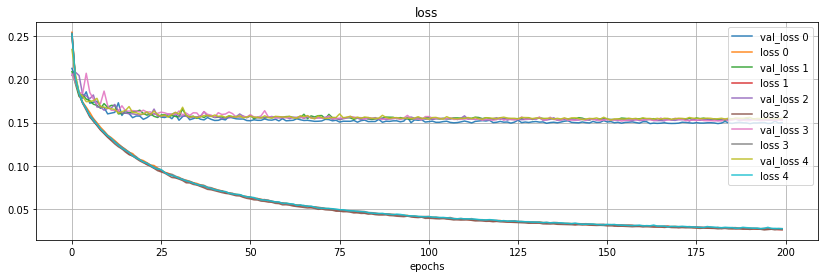

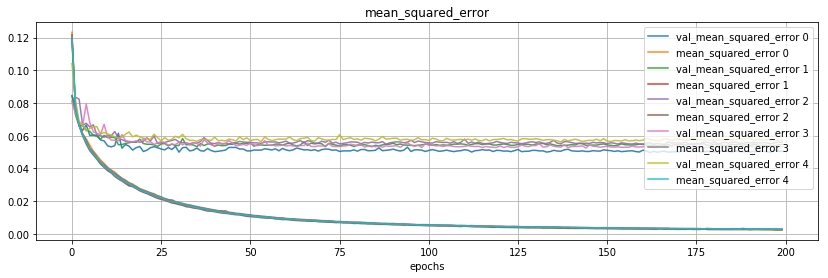

In [22]:
plot_keras_hist(hists)

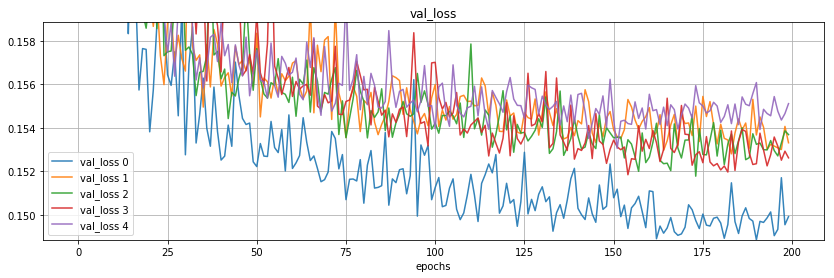

In [23]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss']), 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

### One-fold prediction (haven't run)

In [34]:
params['epochs'] = int(np.mean(best_iterations)*1.15)

In [35]:
params

{'batch_size': 64,
 'epochs': 206,
 'learning_rate': 0.001,
 'n_neurons': (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512),
 'optimizer': keras.optimizers.Adam}

In [36]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                    n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                    optimizer=params['optimizer'])

# Train model
hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                 verbose=2)

# Predict on test set
df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 209, 'village': 2667, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Epoch 1/206
 - 120s - loss: 0.2651 - mean_squared_error: 0.1342
Epoch 2/206
 - 118s - loss: 0.2052 - mean_squared_error: 0.0806
Epoch 3/206
 - 118s - loss: 0.1876 - mean_squared_error: 0.0691
Epoch 4/206
 - 118s - loss: 0.1766 - mean_squared_error: 0.0627
Epoch 5/206
 - 121s - loss: 0.1686 - mean_squared_error: 0.0577
Epoch 6/206
 - 121s - loss: 0.1620 - mean_squared_error: 0.0536
Epoch 7/206
 - 121s - loss: 0.1553 - mean_squared_error: 0.0500
Epoch 8/206
 - 122s - loss: 0.1485 - mean_squared_error: 0.0468
Epoch 9/206
 - 124s - loss: 0.1438 - mean_squared_error: 0.0443
Epoch 10/206
 - 126s - loss: 0.138

Epoch 121/206
 - 119s - loss: 0.0340 - mean_squared_error: 0.0042
Epoch 122/206
 - 119s - loss: 0.0343 - mean_squared_error: 0.0042
Epoch 123/206
 - 125s - loss: 0.0350 - mean_squared_error: 0.0042
Epoch 124/206
 - 120s - loss: 0.0343 - mean_squared_error: 0.0041
Epoch 125/206
 - 119s - loss: 0.0336 - mean_squared_error: 0.0041
Epoch 126/206
 - 119s - loss: 0.0329 - mean_squared_error: 0.0040
Epoch 127/206
 - 118s - loss: 0.0333 - mean_squared_error: 0.0040
Epoch 128/206
 - 118s - loss: 0.0335 - mean_squared_error: 0.0040
Epoch 129/206
 - 118s - loss: 0.0323 - mean_squared_error: 0.0039
Epoch 130/206
 - 118s - loss: 0.0326 - mean_squared_error: 0.0039
Epoch 131/206
 - 118s - loss: 0.0333 - mean_squared_error: 0.0040
Epoch 132/206
 - 118s - loss: 0.0332 - mean_squared_error: 0.0040
Epoch 133/206
 - 118s - loss: 0.0325 - mean_squared_error: 0.0039
Epoch 134/206
 - 118s - loss: 0.0324 - mean_squared_error: 0.0039
Epoch 135/206
 - 118s - loss: 0.0327 - mean_squared_error: 0.0039
Epoch 136/

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.568054e+07
1,BTshNOJyKHnT2YIT,4.024808e+06
2,dhdymr0lV8N5kZOT,1.232749e+07
3,VEwyGGMcD56w5BOc,6.866298e+06
4,wmUeMoJZfsqaSX9b,1.040580e+06
5,EtBjGAHmHCe9t7TZ,2.001168e+06
6,hPNH34vmaZtvBtqc,1.265585e+07
7,wXjeI38bYDMJJwZC,6.341510e+06
8,fxZSGX6aPAFKU8W4,1.719071e+06
9,ewr0Fx6ign87OwaV,4.463393e+06


In [37]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Result

Round 2:

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]

### Hist

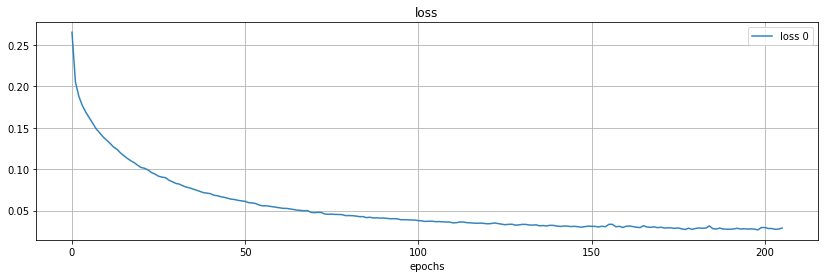

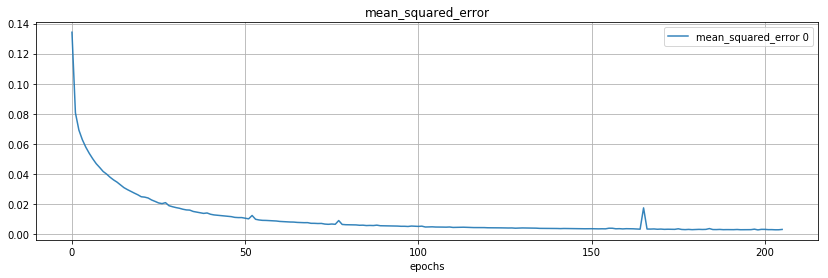

In [38]:
plot_keras_hist(hist)

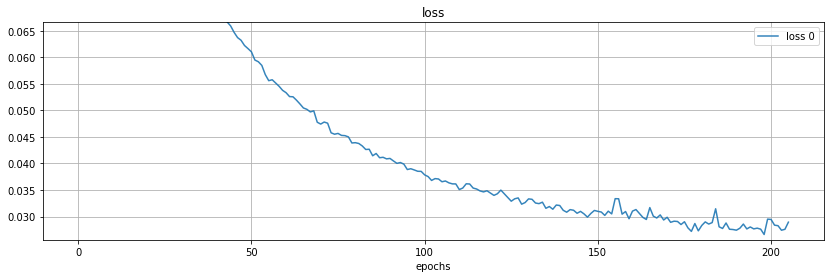

In [42]:
plot_keras_hist(hist, ylim=(min(hist.history['loss'])-0.001, 
                            min(hist.history['loss'])+0.04), metrics_plot=['loss'])